# **Chapter 06-a. Resizing**
* 前置處理的目標包括: `形狀轉換`, `加強資料品質`, 和 `改善模型品質`
* `形狀轉換`: 輸入影像需要轉換為一致的大小
* `加強資料品質`: 例如: 某些影像比其他更暗時, 會希望轉換影像中的像素值, 以獲得一致的白平衡
* `改善模型品質`: 例如: optimizer 在資料值較小時效果最佳, 所以可以在前置階段將像素值縮放到 [0, 1] 或 [-1, 1]; 或是執行 data augmentation -> 部分資料可能不適合, 例如: 文本、男女襯衫的鈕扣方向

In [1]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

Reading TFRecord

(240, 320, 3)
tf.Tensor(0.35263804, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(213, 320, 3)
tf.Tensor(0.69847876, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.22729655, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(333, 500, 3)
tf.Tensor(0.2767833, shape=(), dtype=float32)
tf.Tensor(4, shape=(), dtype=int64)
(240, 320, 3)
tf.Tensor(0.39305505, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


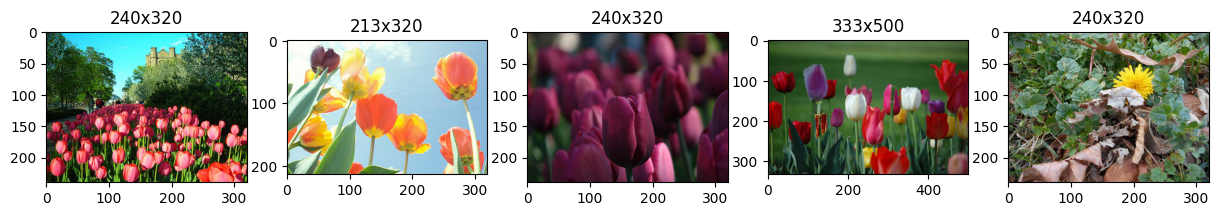

In [ ]:
# parse_tfr 會為了提高儲存效率, 將可變長度陣列儲存為稀疏張量(sparse tensor)
# VarLenFeature（可變長度）：解析時會得到 SparseTensor，不用事先固定長度
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.VarLenFeature(tf.int64),
        'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    }
    rec = tf.io.parse_single_example(
        proto, feature_description
    )
    shape = tf.sparse.to_dense(rec['shape'])                      # 把稀疏的 shape 轉成 dense 向量（例如 [H, W, C]）
    img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)     # 先把 image 從 SparseTensor → dense 向量，再用 shape 把它 還原成 (H, W, C)
    label_int = rec['label_int']
    return img, label_int

train_dataset = tf.data.TFRecordDataset(
    [filename for filename in tf.io.gfile.glob(
        'gs://practical-ml-vision-book-data/flowers_tfr/train-*')
    ], compression_type='GZIP').map(parse_tfr)

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.take(5)):
    print(img.shape)
    mean_of_image = tf.reduce_mean(img)
    print(mean_of_image)
    print(label_int)
    ax[idx].imshow((img.numpy()))
    ax[idx].set_title('{}x{}'.format(img.shape[0], img.shape[1]))

Resizing

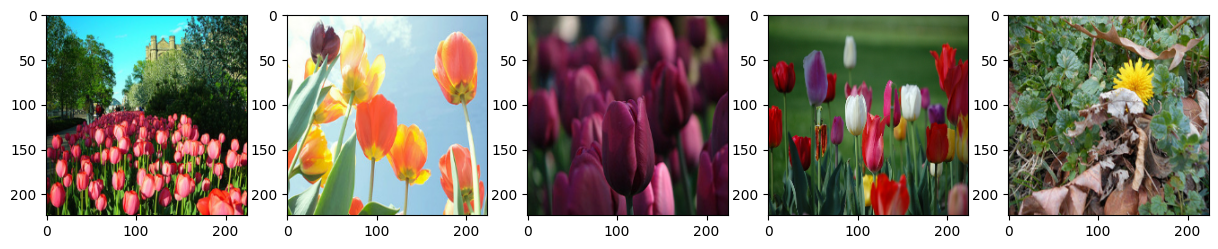

In [ ]:
import tensorflow.keras.layers as layers
preproc_layers = tf.keras.Sequential([          # 用以進行 resizing 的步驟
    layers.Resizing(
        height=IMG_HEIGHT, width=IMG_WIDTH,
        )
    ])

def apply_preproc(img, label):
    img.set_shape([None, None, 3])   # 告訴 TF 這一定是 (H, W, 3)
    x = preproc_layers(img)          # 直接 resize
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))

如何讓影像比例不失真？ -> 先做 Zero Padding, 再做 center crop！
* 為什麼不直接 center crop 就好, 是為了避免 crop 完的大小比 IMG_HEIGHT 或 IMG_WIDTH 還小

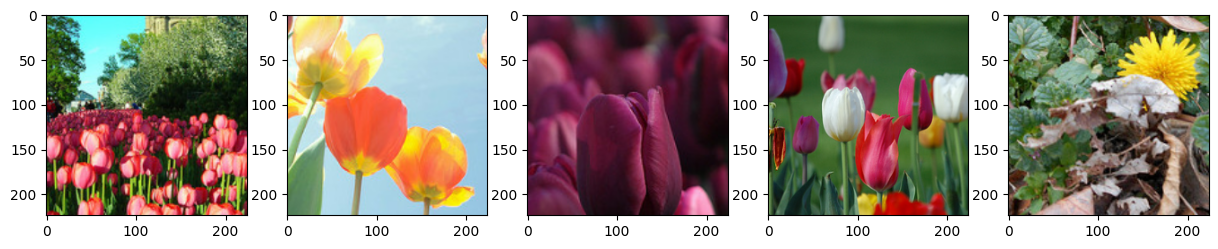

In [16]:
import tensorflow.keras.layers as layers
preproc_layers = tf.keras.Sequential([
    layers.Lambda(lambda img:
                           tf.image.resize_with_pad(
                               img, 2*IMG_HEIGHT, 2*IMG_WIDTH)),
    layers.CenterCrop(
        height=IMG_HEIGHT, width=IMG_WIDTH)
    ])

def apply_preproc(img, label):
    img.set_shape([None, None, 3])   # 告訴 TF 這一定是 (H, W, 3)
    x = preproc_layers(img)          # 直接 resize
    return x, label

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label_int) in enumerate(train_dataset.map(apply_preproc).take(5)):
    ax[idx].imshow((img.numpy()))